In [1]:
#yiming
#imports packages
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
import matplotlib.pyplot as plt

In [2]:
#1. choosing a pair
#MY CHOICE IS THE ENERGY SECTOR
tickers = ['APA','BKR','COG','COP','CVX','DVN','EOG','FANG','HAL','HES','HFC','KMI','MPC','MRO','NOV','OKE','OXY','PSX','PXD','SLB','VLO','WMB','XOM'] 
data = yf.download(tickers, start='2015-01-01',end='2021-01-01')
df1 = data['Adj Close'].dropna(how='all')
df1.head()

[*********************100%***********************]  23 of 23 completed


,APA,BKR,COG,COP,CVX,DVN,EOG,FANG,HAL,HES,...,MRO,NOV,OKE,OXY,PSX,PXD,SLB,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,55.711475,33.761242,28.109787,57.289810,85.623070,53.132568,84.866158,56.920700,34.926056,65.828957,...,25.857536,60.103676,32.977291,61.457245,58.086002,143.934845,69.699425,38.790855,30.521172,69.679512
2015-01-05,52.290070,33.154171,26.568890,54.563313,82.200562,51.162777,79.750648,54.403767,34.236198,62.641396,...,24.655071,57.359596,31.087971,59.178776,54.574642,134.274490,67.811943,37.195766,29.313015,67.772957
2015-01-06,51.722733,33.051998,26.195332,52.310635,82.162544,50.116856,77.478096,54.489246,33.900116,61.673592,...,24.284388,56.652916,29.793180,58.675858,53.047962,133.919205,66.485786,36.741116,28.914797,67.412659
2015-01-07,51.146667,33.941559,26.419462,52.659748,82.094101,50.352196,76.990463,55.325062,34.811073,61.531517,...,24.582741,56.707985,29.575178,58.683460,53.280975,132.449982,66.477654,36.456005,28.759560,68.095718
2015-01-08,53.127949,34.278149,26.951775,53.973122,83.972679,52.138958,79.934639,58.022457,35.562847,63.378357,...,25.079998,58.396648,29.898878,59.201649,55.354050,135.791748,67.283104,38.544277,29.036289,69.229149


In [3]:
#2.check the cointegration and choose a pair
def find_cointegrated_pairs(data):
    pairs = []
    k = data.shape[1]
    #getting the number of columns (tickers)
    p_values = np.ones( (k, k) ) 
    keys = data.keys()
    #getting the column names (tickers) from df
    for i in range(k):
        for j in range(i+1, k):
            Asset_1 = data[keys[i]]
            Asset_2 = data[keys[j]]
            #iterating through the df and testing cointegration for all pairs of tickers
            Coint_Test = coint(Asset_1, Asset_2)      
            pvalue = Coint_Test[1]
            # statsmodels coint returns p-values (our primary concern) in the 1th index slot
            p_values[i, j] = pvalue
            #p value matrix where the output of the coint test is the ith, jth index
            if pvalue < 0.025:
                pairs.append((keys[i], keys[j]))
                
    return p_values, pairs

In [4]:
pvalues, pairs = find_cointegrated_pairs(df1)
print(pairs)

[('APA', 'SLB'), ('BKR', 'NOV'), ('COP', 'HFC'), ('CVX', 'OKE'), ('DVN', 'NOV'), ('EOG', 'FANG'), ('HAL', 'NOV'), ('HES', 'HFC'), ('HES', 'VLO'), ('NOV', 'OXY'), ('NOV', 'PXD'), ('NOV', 'SLB')]


In [5]:
coint(df1['BKR'],df1['NOV'])
#This pairs with a p-value of less than 0.025 which is 0.019
#Thus we can reject the null hypothesis and they can be cointegrated.

(-3.6877812366698164,
 0.018998721358136177,
 array([-3.90370762, -3.34017942, -3.04725993]))

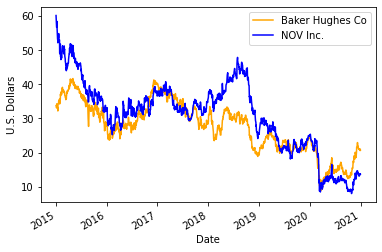

In [6]:
#visualize this pair
df1['BKR'].plot(color = 'orange')
df1['NOV'].plot(color = 'blue')
plt.legend(['Baker Hughes Co', 'NOV Inc.'])
plt.ylabel('U.S. Dollars')
plt.show()

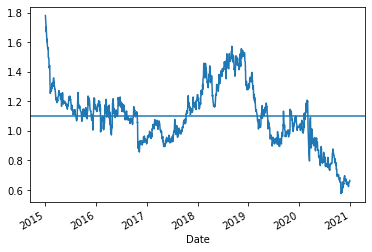

In [7]:
#lets see whether they have a mean reversion price ratio 
price_ratio = df1['NOV']/df1['BKR']
price_ratio.plot()
plt.axhline(price_ratio.mean())
plt.show()

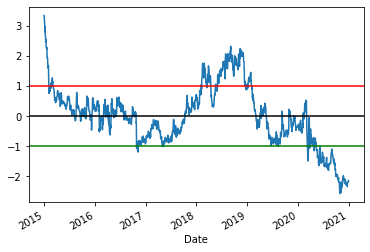

Date
2015-01-02    3.334181
2015-01-05    3.088044
2015-01-06    3.009386
2015-01-07    2.796950
2015-01-08    2.958153
                ...   
2020-12-24   -2.221594
2020-12-28   -2.187592
2020-12-29   -2.186538
2020-12-30   -2.176937
2020-12-31   -2.142640
Length: 1511, dtype: float64


In [8]:
#Z Score (Value) = (Value — Mean) / Standard Deviation
def zscore(ratios):
     return (ratios - ratios.mean()) / np.std(ratios)
zscore(price_ratio).plot()
plt.axhline(zscore(price_ratio).mean(),color='black')
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()
print(zscore(price_ratio))

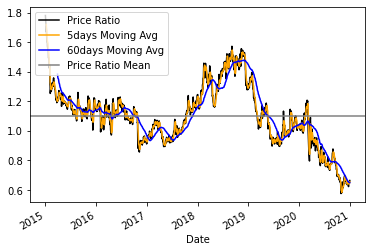

In [11]:
#moving averages
MA_5 = price_ratio.rolling(window=5).mean() 
MA_60 = price_ratio.rolling(window=60).mean() 
price_ratio.plot(color = 'black')
MA_5.plot(color = 'orange')
MA_60.plot(color = 'blue')
plt.axhline(price_ratio.mean(), color = 'grey')
plt.legend(['Price Ratio', '5days Moving Avg', '60days Moving Avg', 'Price Ratio Mean'])
plt.show()

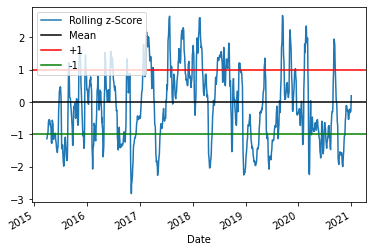

In [12]:
#rolling zscores of moving averages
std_60 = price_ratio.rolling(window=60).std()
rolling_zscores = (MA_5 - MA_60)/std_60
rolling_zscores.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.legend(['Rolling z-Score', 'Mean', '+1', '-1'])
plt.show()
#very good mean reverion price ratio base on the rolling z-scores visulization 

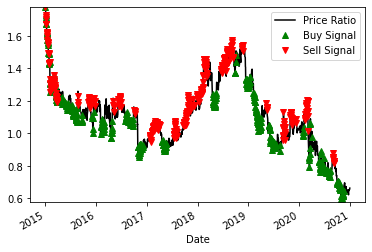

In [13]:
#when price ratio below the -1 z-score, we think it is undervalued
#it will return to 0, so we buy(1)
#when price ratio above the 1 z-score, we think it is overvalued
#it will return to 0, so we sell(-1)
price_ratio.plot(color = 'black')
buy  = price_ratio.copy()
sell = price_ratio.copy()
buy[rolling_zscores > -1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell[rolling_zscores < 1] = 0
sell.plot(color='r', linestyle='None', marker='v')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,price_ratio.min(),price_ratio.max()))
plt.legend(['Price Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

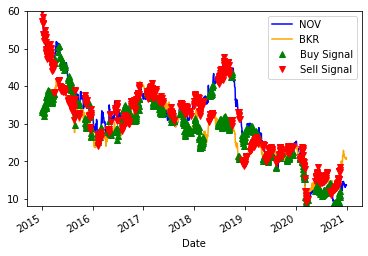

In [14]:
# Plot the prices and buy and sell signals from z score
stock1 = df1['NOV']
stock2 = df1['BKR']
stock1.plot(color='blue')
stock2.plot(color='orange')
buy_the_ratio = 0*stock1.copy()
sell_the_ratio = 0*stock1.copy()
# When buying the ratio, buy higher stock1 and sell lower stock2
buy_the_ratio[buy!=0] = stock1[buy!=0]
buy_the_ratio[sell!=0] = stock2[sell!=0]
# When selling the ratio, sell higer stock1 and buy lower stock2
sell_the_ratio[buy!=0] = stock2[buy!=0]
sell_the_ratio[sell!=0] = stock1[sell!=0]
buy_the_ratio.plot(color='g', linestyle='None', marker='^')
sell_the_ratio.plot(color='r', linestyle='None', marker='v')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(stock1.min(),stock2.min()),max(stock1.max(),stock2.max())))
plt.legend(['NOV','BKR', 'Buy Signal', 'Sell Signal'])
plt.show()

In [16]:
#4.backtest(PNL,SHARP RATIO, DRAWDOWNS)
stock1 = 'NOV'
stock2 = 'BKR'
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['stock1'] = df1[stock1] 
signals['stock2'] = df1[stock2]
ratios = signals.stock1 / signals.stock2
MA1 = ratios.rolling(5).mean()
MA2 = ratios.rolling(60).mean()
std = ratios.rolling(60).std()
# calculate z-score 
signals['z'] = ((MA1-MA2)/std)
signals['z upper limit'] = 1
signals['z lower limit'] = -1
# create signal 
#sell the ratio if z-score is greater than 1 , buy the ratio if z-score is less than 1
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
# if the buy or sell signals keep appearing, we only count the first signal
# which means 1 sell signal following 1 buy signal  
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()
# verify datafame
signals

,stock1,stock2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
Date,,,,,,,,,
2015-01-02,60.103676,33.761242,NaN,1,-1,0,NaN,0,NaN
2015-01-05,57.359596,33.154171,NaN,1,-1,0,0.0,0,0.0
2015-01-06,56.652916,33.051998,NaN,1,-1,0,0.0,0,0.0
2015-01-07,56.707985,33.941559,NaN,1,-1,0,0.0,0,0.0
2015-01-08,58.396648,34.278149,NaN,1,-1,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,13.500000,20.838722,-0.316030,1,-1,0,0.0,0,0.0
2020-12-28,13.560000,20.709782,-0.288385,1,-1,0,0.0,0,0.0
2020-12-29,13.480000,20.580843,-0.130289,1,-1,0,0.0,0,0.0


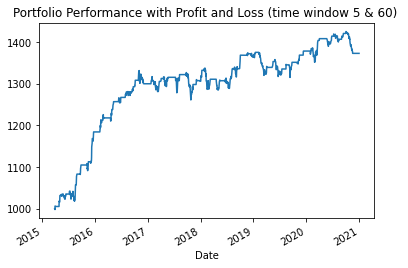

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
Date,,,,,,,,,,,,,,,,
2015-03-30,46.159805,369.278442,130.721558,500.000000,0.000000,1.0,38.258999,-459.107986,959.107986,500.000000,0.000000,-1.0,-1.136717,1000.000000,1,-1
2015-03-31,46.298725,370.389801,130.721558,501.111359,0.002223,0.0,38.319275,-459.831299,959.107986,499.276688,-0.001447,0.0,-1.111887,1000.388046,1,-1
2015-04-01,46.233898,369.871185,130.721558,500.592743,-0.001035,0.0,38.469944,-461.639328,959.107986,497.468658,-0.003621,0.0,-1.079981,998.061401,1,-1
2015-04-02,47.243408,377.947266,130.721558,508.668823,0.016133,0.0,38.427746,-461.132950,959.107986,497.975037,0.001018,0.0,-1.025167,1006.643860,1,-1
2015-04-06,48.808605,0.000000,521.190399,521.190399,0.024616,-1.0,39.572872,0.000000,484.233521,484.233521,-0.027595,1.0,-0.970296,1005.423920,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,13.500000,0.000000,839.716194,839.716194,0.000000,0.0,20.838722,0.000000,532.873989,532.873989,0.000000,0.0,-0.316030,1372.590183,1,-1
2020-12-28,13.560000,0.000000,839.716194,839.716194,0.000000,0.0,20.709782,0.000000,532.873989,532.873989,0.000000,0.0,-0.288385,1372.590183,1,-1
2020-12-29,13.480000,0.000000,839.716194,839.716194,0.000000,0.0,20.580843,0.000000,532.873989,532.873989,0.000000,0.0,-0.130289,1372.590183,1,-1


In [17]:
# total initial money set at 1000 usd
money = 1000

# shares to buy for each position, floor divison
positions1 = (money/2)// max(signals['stock1'])
positions2 = (money/2)// max(signals['stock2'])

# since there are two stocks, we calculate each asset Pnl separately 
# and we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['stock1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['stock1'] * positions1
portfolio['cash1'] = money/2 - (signals['positions1'] * signals['stock1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['stock2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['stock2'] * positions2
portfolio['cash2'] = money/2 - (signals['positions2'] * signals['stock2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score

portfolio['total asset'].plot()
plt.title('Portfolio Performance with Profit and Loss (time window 5 & 60) ')
plt.show()
portfolio

In [18]:
#calculate the daily return
df_daily_returns = portfolio['total asset'].pct_change()
#Calculate the cumulative daily returns 
df_cum_returns = (df_daily_returns + 1).cumprod()

In [19]:
highwatermarks = df_cum_returns.cummax()
print(highwatermarks.dropna())

Date
2015-03-31    1.000388
2015-04-01    1.000388
2015-04-02    1.006644
2015-04-06    1.006644
2015-04-07    1.006644
                ...   
2020-12-24    1.424986
2020-12-28    1.424986
2020-12-29    1.424986
2020-12-30    1.424986
2020-12-31    1.424986
Name: total asset, Length: 1451, dtype: float64


In [20]:
#drawdown rate
drawdown_rate =(df_cum_returns-highwatermarks)/highwatermarks

In [21]:
max_drawdown_rate = min(drawdown_rate.dropna())
print("ALL drawdowns rate:")
print(drawdown_rate)
print("Maximum drawdowns rate:")
print(max_drawdown_rate)

ALL drawdowns rate:
Date
2015-03-30         NaN
2015-03-31    0.000000
2015-04-01   -0.002326
2015-04-02    0.000000
2015-04-06   -0.001212
                ...   
2020-12-24   -0.036770
2020-12-28   -0.036770
2020-12-29   -0.036770
2020-12-30   -0.036770
2020-12-31   -0.036770
Name: total asset, Length: 1452, dtype: float64
Maximum drawdowns rate:
-0.05289108994276664


In [22]:
#drawdown depth
drawdown_depth = df_cum_returns-highwatermarks
search = 0.000000 
recoverpoint = drawdown_depth.loc[drawdown_depth.isin([search])].index.tolist()

In [23]:
duration = [recoverpoint[i+1]-recoverpoint[i] for i in range(len(recoverpoint)-1)]
print("Duration for each drawdowns:")
duration

Duration for each drawdowns:


[Timedelta('2 days 00:00:00'),
 Timedelta('28 days 00:00:00'),
 Timedelta('5 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('6 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('4 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('19 days 00:00:00'),
 Timedelta('24 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('38 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('3 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('4 days 00:00:00'),
 Tim

In [24]:
#calculate the sharp ratio
returns =  (portfolio['total asset']- portfolio['total asset'].shift(1))/ portfolio['total asset'].shift(1)
sharp_ratio = returns.mean()/returns.std()*np.sqrt(252)
print('sharpe ratio with time window 5 & 60 =',sharp_ratio)

sharpe ratio with time window 5 & 60 = 1.1948638376445269


In [25]:
#5.explore the sensitivity, if change windows to 5, 120
stock1 = 'NOV'
stock2 = 'BKR'
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['stock1'] = df1[stock1] 
signals['stock2'] = df1[stock2]
ratios = signals.stock1 / signals.stock2
MA1 = ratios.rolling(5).mean()
MA2 = ratios.rolling(120).mean()
std = ratios.rolling(120).std()
# calculate z-score 
signals['z'] = ((MA1-MA2)/std)
signals['z upper limit'] = 1
signals['z lower limit'] = -1
# create signal 
#sell the ratio if z-score is greater than 1 , buy the ratio if z-score is less than 1
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)
# if the buy or sell signals keep appearing, we only count the first signal
# which means 1 sell signal following 1 buy signal  
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()
# verify datafame
signals

,stock1,stock2,z,z upper limit,z lower limit,signals1,positions1,signals2,positions2
Date,,,,,,,,,
2015-01-02,60.103676,33.761242,NaN,1,-1,0,NaN,0,NaN
2015-01-05,57.359596,33.154171,NaN,1,-1,0,0.0,0,0.0
2015-01-06,56.652916,33.051998,NaN,1,-1,0,0.0,0,0.0
2015-01-07,56.707985,33.941559,NaN,1,-1,0,0.0,0,0.0
2015-01-08,58.396648,34.278149,NaN,1,-1,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,13.500000,20.838722,-1.024057,1,-1,1,0.0,-1,0.0
2020-12-28,13.560000,20.709782,-1.004577,1,-1,1,0.0,-1,0.0
2020-12-29,13.480000,20.580843,-0.927286,1,-1,0,-1.0,0,1.0


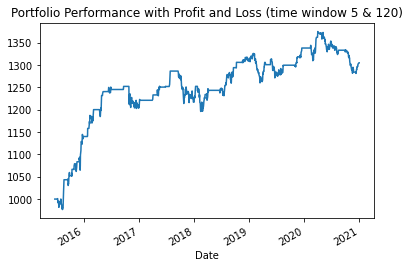

sharpe ratio with time window 5 & 120 = 0.8869053041754155


In [26]:
# total initial money set at 1000 usd
money = 1000

# shares to buy for each position, floor divison
positions1 = (money/2)// max(signals['stock1'])
positions2 = (money/2)// max(signals['stock2'])

# since there are two stocks, we calculate each asset Pnl separately 
# and we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['stock1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['stock1'] * positions1
portfolio['cash1'] = money/2 - (signals['positions1'] * signals['stock1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['stock2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['stock2'] * positions2
portfolio['cash2'] = money/2 - (signals['positions2'] * signals['stock2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score

portfolio['total asset'].plot()
plt.title('Portfolio Performance with Profit and Loss (time window 5 & 120)')
plt.show()
portfolio
returns =  (portfolio['total asset']- portfolio['total asset'].shift(1))/ portfolio['total asset'].shift(1)
sharp_ratio = returns.mean()/returns.std()*np.sqrt(252)
print('sharpe ratio with time window 5 & 120 =',sharp_ratio)